# **1. Library AND Load data**

In [1]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [4]:
# Chọn tệp JSON API Token từ máy tính của bạn
uploaded = files.upload()

# Di chuyển tệp JSON vào thư mục ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
# Tải xuống bộ dữ liệu từ Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Giải nén bộ dữ liệu
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# **2. Processing data**

In [6]:
# Danh sách các labels
labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

# Đường dẫn đến thư mục chứa dữ liệu
path = "/content/COVID-19_Radiography_Dataset"

# Kết hợp đường dẫn
data_dir = os.path.join(path)

# Khởi tạo danh sách data
data = []

# Duyệt qua từng label
for id, label in enumerate(labels):
    # Duyệt qua từng tệp tin trong thư mục của label hiện tại
    for file in os.listdir(os.path.join(data_dir, label + '/images')):
        # Thêm thông tin tệp tin và label vào danh sách data
        data.append(['{}/images/{}'.format(label, file), label])

# Giữ lại 2 cột: 'image_file' và 'result'
data = pd.DataFrame(data, columns=['image_file', 'result'])

# Tạo cột 'path' trong DataFrame data, kết hợp đường dẫn đầy đủ
data['path'] = path + '/' + data['image_file']

In [7]:
# Khởi tạo danh sách pixel_img để lưu trữ các ảnh
pixel_img = []

# Duyệt qua từng đường dẫn ảnh trong data
for image in tqdm(data['path']):
    # Mở ảnh và chuyển đổi sang ảnh đen trắng (grayscale)
    img = Image.open(image)
    img = ImageOps.grayscale(img)

    # Thay đổi kích thước ảnh thành 64x64 pixel
    img = img.resize((64, 64))

    # Chuyển đổi ảnh thành mảng numpy
    img = np.asarray(img)

    # Thay đổi hình dạng của ảnh để có kích thước (64, 64, 1)
    img = img.reshape((64, 64, 1))

    # Thêm ảnh vào danh sách pixel_img
    pixel_img.append(img)

# Chuyển đổi danh sách pixel_img thành mảng numpy
pixel_img = np.array(pixel_img)

# Tạo nhãn cho ảnh dựa trên label từ data
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3})

100%|██████████| 21165/21165 [00:58<00:00, 359.61it/s]


In [8]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Tính kích thước đầu vào
input_size = X_train.shape[1] * X_train.shape[2]

# Định hình lại kích thước của X_train và X_test
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

In [9]:
def evaluate_model(model, X_test, y_test, labels):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính toán các thông số đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # In ra báo cáo phân lớp
    print(classification_report(y_test, y_pred))

    # Tạo ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# **3.2. Random Forest**

In [10]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest

In [11]:
# Random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=1)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=1)

Accuracy: 0.8317977793527049
Precision: 0.8338217319727292
Recall: 0.8317977793527049
F1-score: 0.8298434944609049
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2038
           1       0.88      0.69      0.77       723
           2       0.79      0.78      0.79      1203
           3       0.92      0.82      0.87       269

    accuracy                           0.83      4233
   macro avg       0.86      0.80      0.82      4233
weighted avg       0.83      0.83      0.83      4233



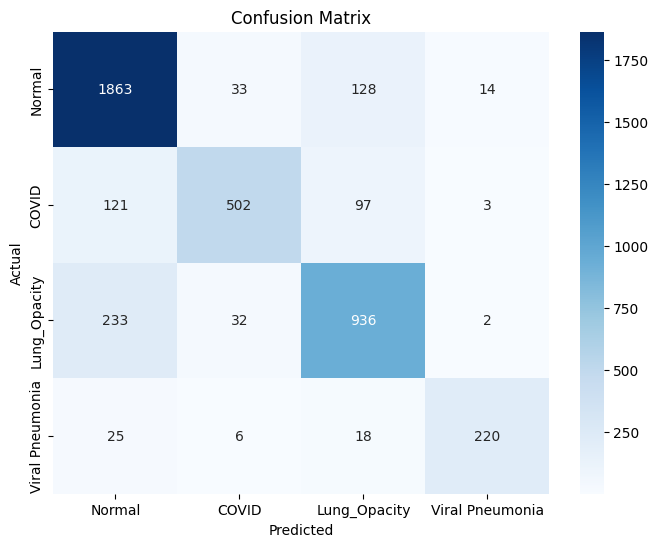

In [12]:
evaluate_model(rf_model, X_test, y_test, labels)

In [13]:
# save
joblib.dump(rf_model, "/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_normal.pkl")

['/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_normal.pkl']

## Random Forest - Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
# Xác định số lượng mẫu trong từng lớp
num_samples = y_train.value_counts().to_dict()

# Tìm lớp có số lượng mẫu lớn nhất
max_samples = max(num_samples.values())

# Xác định tỷ lệ oversampling cho từng lớp
oversampling_ratio = 2
sampling_strategy = {}
for label, count in num_samples.items():
    oversampling_count = count * oversampling_ratio
    sampling_strategy[label] = oversampling_count


over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_oversampling, y_oversampling = over_sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (16308) in class 0 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (9618) in class 2 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(


In [19]:
# Random forest classifier
rf_model_oversampling = RandomForestClassifier(n_estimators=100, n_jobs=1)
rf_model_oversampling.fit(X_oversampling,y_oversampling)

RandomForestClassifier(n_jobs=1)

Accuracy: 0.8322702575005906
Precision: 0.8342991155631718
Recall: 0.8322702575005906
F1-score: 0.8304769856555888
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2038
           1       0.87      0.70      0.78       723
           2       0.80      0.78      0.79      1203
           3       0.94      0.82      0.88       269

    accuracy                           0.83      4233
   macro avg       0.86      0.80      0.83      4233
weighted avg       0.83      0.83      0.83      4233



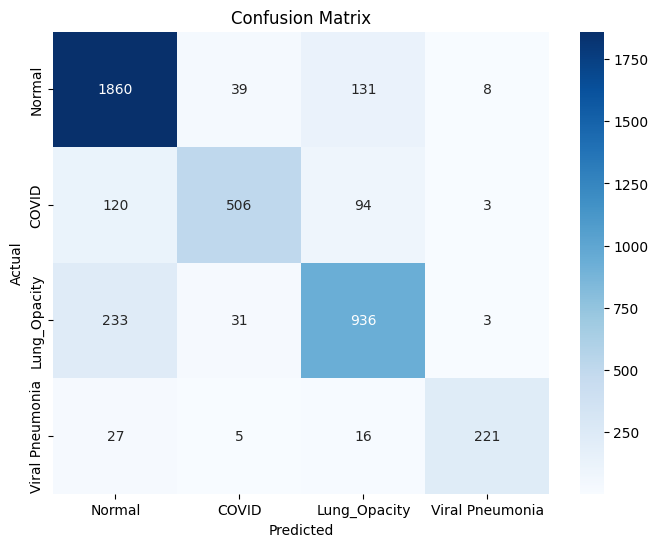

In [20]:
evaluate_model(rf_model_oversampling, X_test, y_test, labels)

In [21]:
# save
joblib.dump(rf_model_oversampling, "/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_Oversampling.pkl")

['/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_Oversampling.pkl']

## Random Forest - Kết hợp Oversampling và Undersampling

In [22]:
from imblearn.combine import SMOTEENN

In [23]:
sampler = SMOTEENN()
X_over_under_sampling, y_over_under_sampling = sampler.fit_resample(X_train, y_train)

In [24]:
# Random forest classifier
rf_over_under_model = RandomForestClassifier(n_estimators=100, n_jobs=1)
rf_over_under_model.fit(X_over_under_sampling, y_over_under_sampling)

RandomForestClassifier(n_jobs=1)

Accuracy: 0.7639971651311127
Precision: 0.7990969006464598
Recall: 0.7639971651311127
F1-score: 0.7663084454665352
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      2038
           1       0.61      0.89      0.72       723
           2       0.74      0.79      0.76      1203
           3       0.65      0.97      0.78       269

    accuracy                           0.76      4233
   macro avg       0.73      0.83      0.76      4233
weighted avg       0.80      0.76      0.77      4233



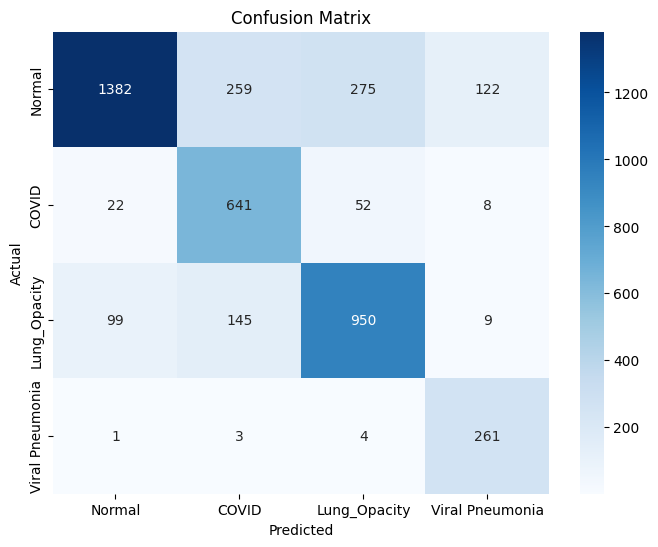

In [25]:
evaluate_model(rf_over_under_model, X_test, y_test, labels)

In [26]:
# save
joblib.dump(rf_over_under_model, "/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_Over_Under.pkl")

['/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_Over_Under.pkl']

## Random Forest - Weighted Loss Function (sample weights)

In [27]:
from sklearn.utils import compute_sample_weight

In [28]:
# Tính toán trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [32]:
# Khởi tạo và huấn luyện mô hình RandomForestClassifier
rf_sample_weight_model = RandomForestClassifier(n_estimators=100, n_jobs=1)
rf_sample_weight_model.fit(X_train, y_train, sample_weight=sample_weights)

RandomForestClassifier(n_jobs=1)

Accuracy: 0.83723127805339
Precision: 0.8413394850288798
Recall: 0.83723127805339
F1-score: 0.8354757279682629
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2038
           1       0.91      0.72      0.80       723
           2       0.81      0.77      0.79      1203
           3       0.95      0.80      0.87       269

    accuracy                           0.84      4233
   macro avg       0.87      0.80      0.83      4233
weighted avg       0.84      0.84      0.84      4233



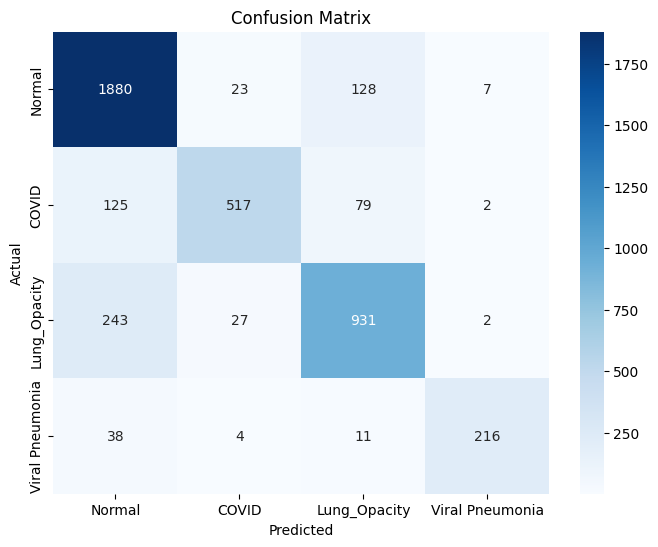

In [33]:
evaluate_model(rf_sample_weight_model, X_test, y_test, labels)

In [34]:
# save
joblib.dump(rf_sample_weight_model, "/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_sample_weight.pkl")

['/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_sample_weight.pkl']

## Random Forest - Weighted Loss Function (class weights)

In [35]:
from sklearn.utils import compute_class_weight

In [36]:
# Tính toán trọng số lớp
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Chuyển đổi trọng số lớp thành một từ điển
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [38]:
# Khởi tạo và huấn luyện mô hình RandomForestClassifier
rf_class_weight_model = RandomForestClassifier(n_estimators=100, n_jobs=1, class_weight=class_weights_dict)
rf_class_weight_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5191317144959529,
                                     1: 1.4631870031109575,
                                     2: 0.8802245789145352,
                                     3: 3.934014869888476},
                       n_jobs=1)

Accuracy: 0.8339239310181904
Precision: 0.8376738218012489
Recall: 0.8339239310181904
F1-score: 0.8321239376603534
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2038
           1       0.90      0.71      0.79       723
           2       0.80      0.77      0.79      1203
           3       0.94      0.79      0.86       269

    accuracy                           0.83      4233
   macro avg       0.87      0.80      0.83      4233
weighted avg       0.84      0.83      0.83      4233



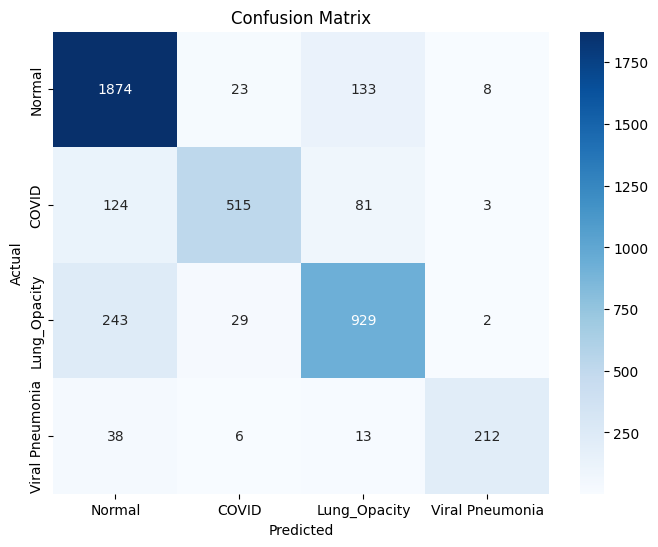

In [39]:
evaluate_model(rf_class_weight_model, X_test, y_test, labels)

In [40]:
# save
joblib.dump(rf_class_weight_model, "/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_class_weight.pkl")

['/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/rf_class_weight.pkl']